# Taller teórico - práctico sobre redes neuronales

Dr. Héctor Henríquez Leighton



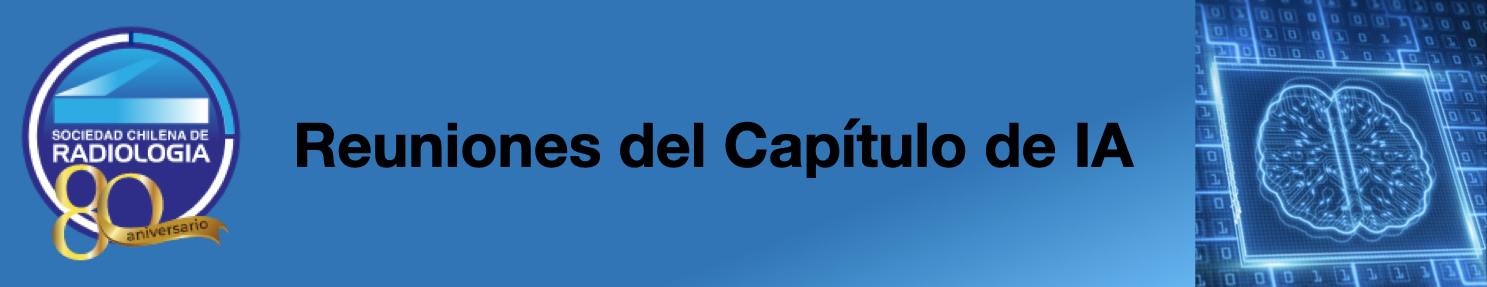

In [ ]:
!pip3 install keras-visualizer

In [ ]:
## Herramientas generales
import numpy as np 
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import cv2
import os

## Construcción de modelos
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
#from tensorflow.keras import regularizers
#from tensorflow.keras.regularizers import l1, l2
from keras_visualizer import visualizer

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def read_images(path_dir):
  images = []
  labels = []
  for modality in os.listdir(path_dir):
    modality_dir = os.path.join(path_dir, modality)
    for exam in os.listdir(modality_dir):
      image = cv2.imread(os.path.join(modality_dir, exam))
      images.append(image)
      labels.append(modality)
  images = np.array(images)
  labels = np.array(labels)
  np.random.seed(10)
  np.random.shuffle(images)
  np.random.seed(10)
  np.random.shuffle(labels)
  return(images, labels)
    
def MapaActivacion(img_tensor, modelo):
    
    grad_model = tf.keras.models.Model(
          [model.inputs], [model.get_layer('conv2d_1').output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model([img_tensor])
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap_array =np.array(heatmap)
    heatmap_resize = cv2.resize(heatmap_array, (img_tensor.shape[2],img_tensor.shape[1]),
               interpolation = cv2.INTER_CUBIC)
    heatmap_color = cv2.applyColorMap(np.uint8(255*heatmap_resize), cv2.COLORMAP_HSV) 

  
    return(heatmap_array, heatmap_color)

In [ ]:
!wget -N "https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/MedNIST.zip"
!unzip -qo "MedNIST.zip"
!rm "MedNIST.zip"
train_dir = '/content/Medical/Medical_train'
test_dir =  '/content/Medical/Medical_test'
classes = os.listdir(train_dir)
classes = np.array(classes)
print("Clases de estudios:", classes)

In [ ]:
for modality in os.listdir(train_dir):
  modality_dir = os.path.join(train_dir, modality)
  print("Numero de estudios para la clase {}: {}".format(modality, len(os.listdir(modality_dir))))

## Lectura y procesamiento de las imágenes

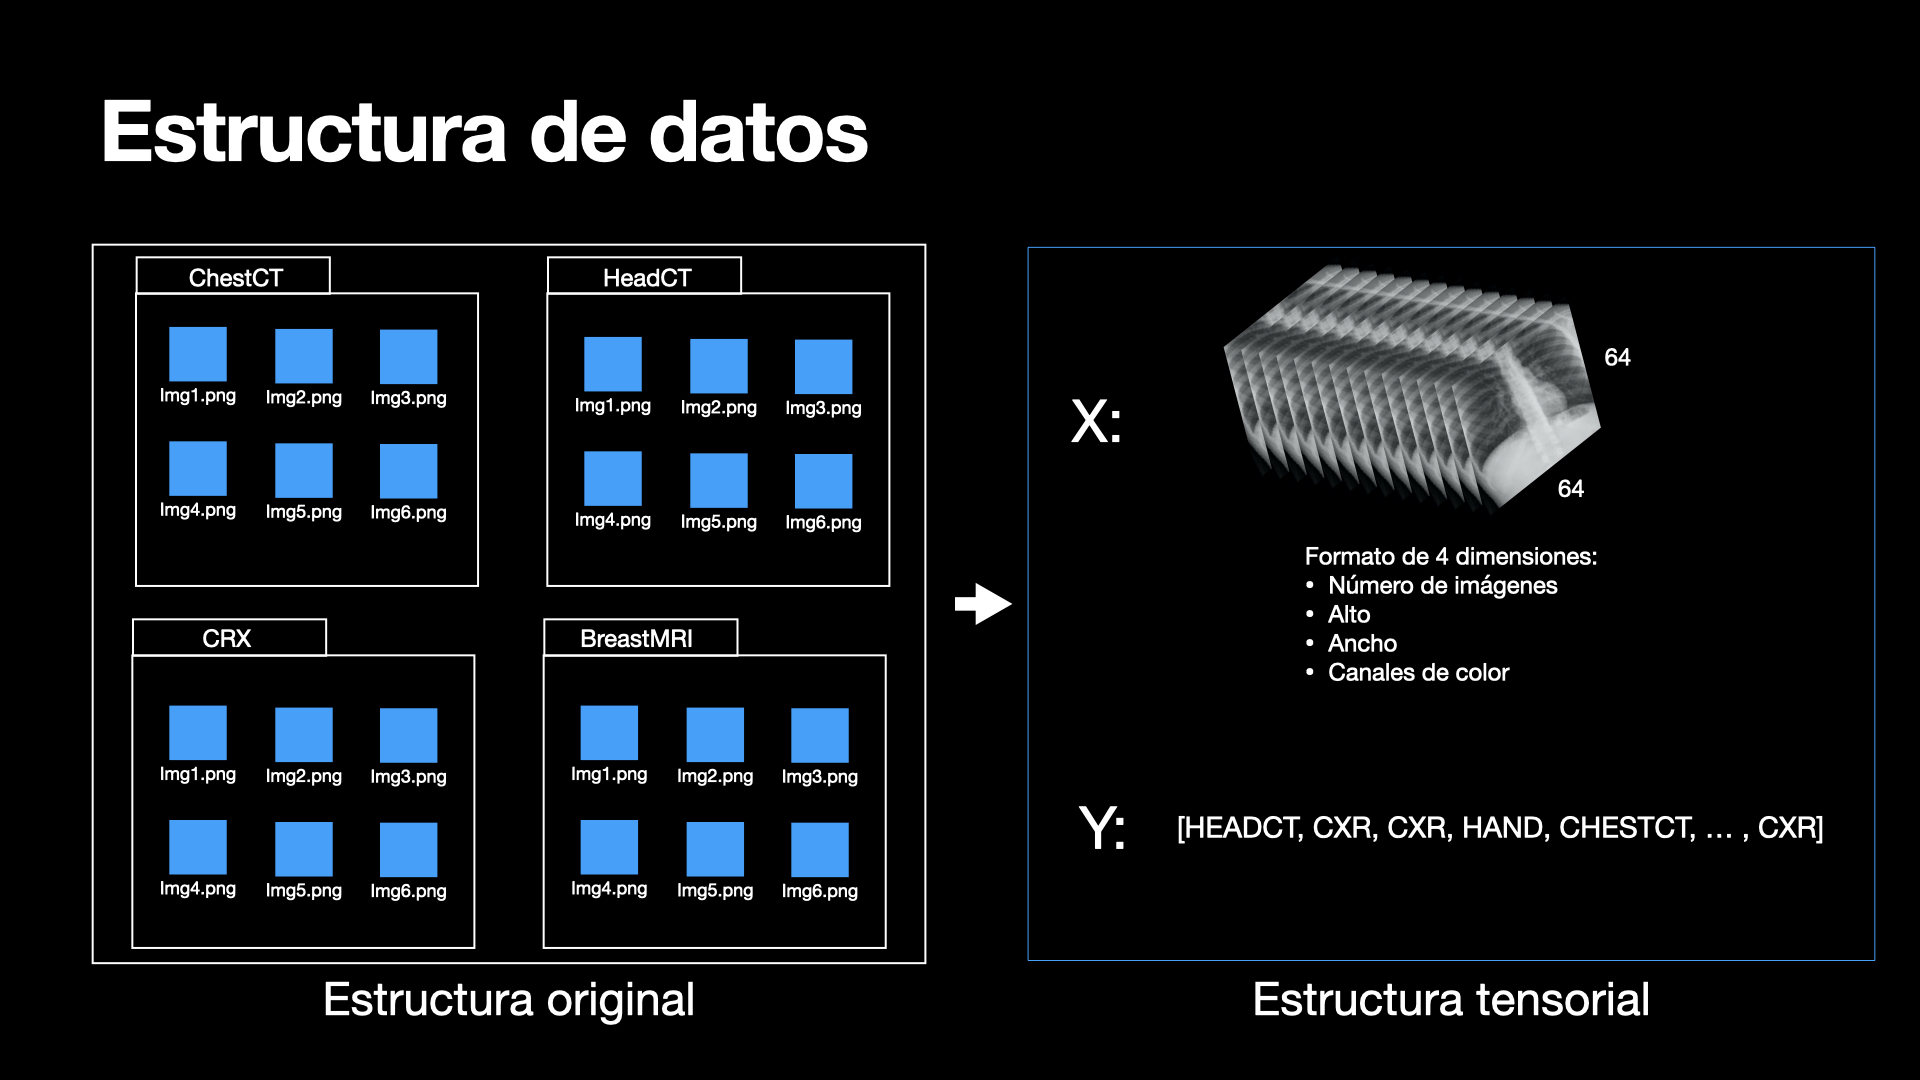

In [ ]:
X_train, y_train = read_images(train_dir)
X_test, y_test = read_images(test_dir)
X_train = (X_train/255).astype('float32')
X_test = (X_test/255).astype('float32')

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
ROWS = 8
fig, axes1 = plt.subplots(ROWS,ROWS,figsize=(10,10))
for j in range(ROWS):
    for k in range(ROWS):
        i = np.random.randint(0, X_train.shape[0])
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X_train[i,:,:,:], cmap='gray')
        axes1[j][k].set_title(y_train[i], size=8)
      

In [ ]:
## Visualización por modalidad
#'Hand' 'BreastMRI' 'ChestCT' 'HeadCT' 'AbdomenCT' 'CXR'

modality = 'HeadCT'

ROWS = 4
fig, axes1 = plt.subplots(ROWS,ROWS,figsize=(8,8))
for j in range(ROWS):
    for k in range(ROWS):
        i = np.random.randint(0, X_train[np.where(y_train == modality)].shape[0])
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X_train[np.where(y_train == modality)][i,:,:,:], cmap='gray')
        axes1[j][k].set_title(modality, size=8)
      

In [ ]:
## Visualización de etiquetas:
print(y_train[0:10])

In [ ]:
### Preprocesamiento de etiquetas

train_labels = np.zeros((y_train.shape[0], len(classes)))
test_labels = np.zeros((y_test.shape[0], len(classes)))

for i in range(train_labels.shape[0]):
  train_labels[i, np.where(classes == y_train[i])] = 1

for i in range(test_labels.shape[0]):
  test_labels[i, np.where(classes == y_test[i])] = 1
  

In [ ]:
print(classes)
print(train_labels[0:10])

### Construcción Modelo de red neuronal convolucional

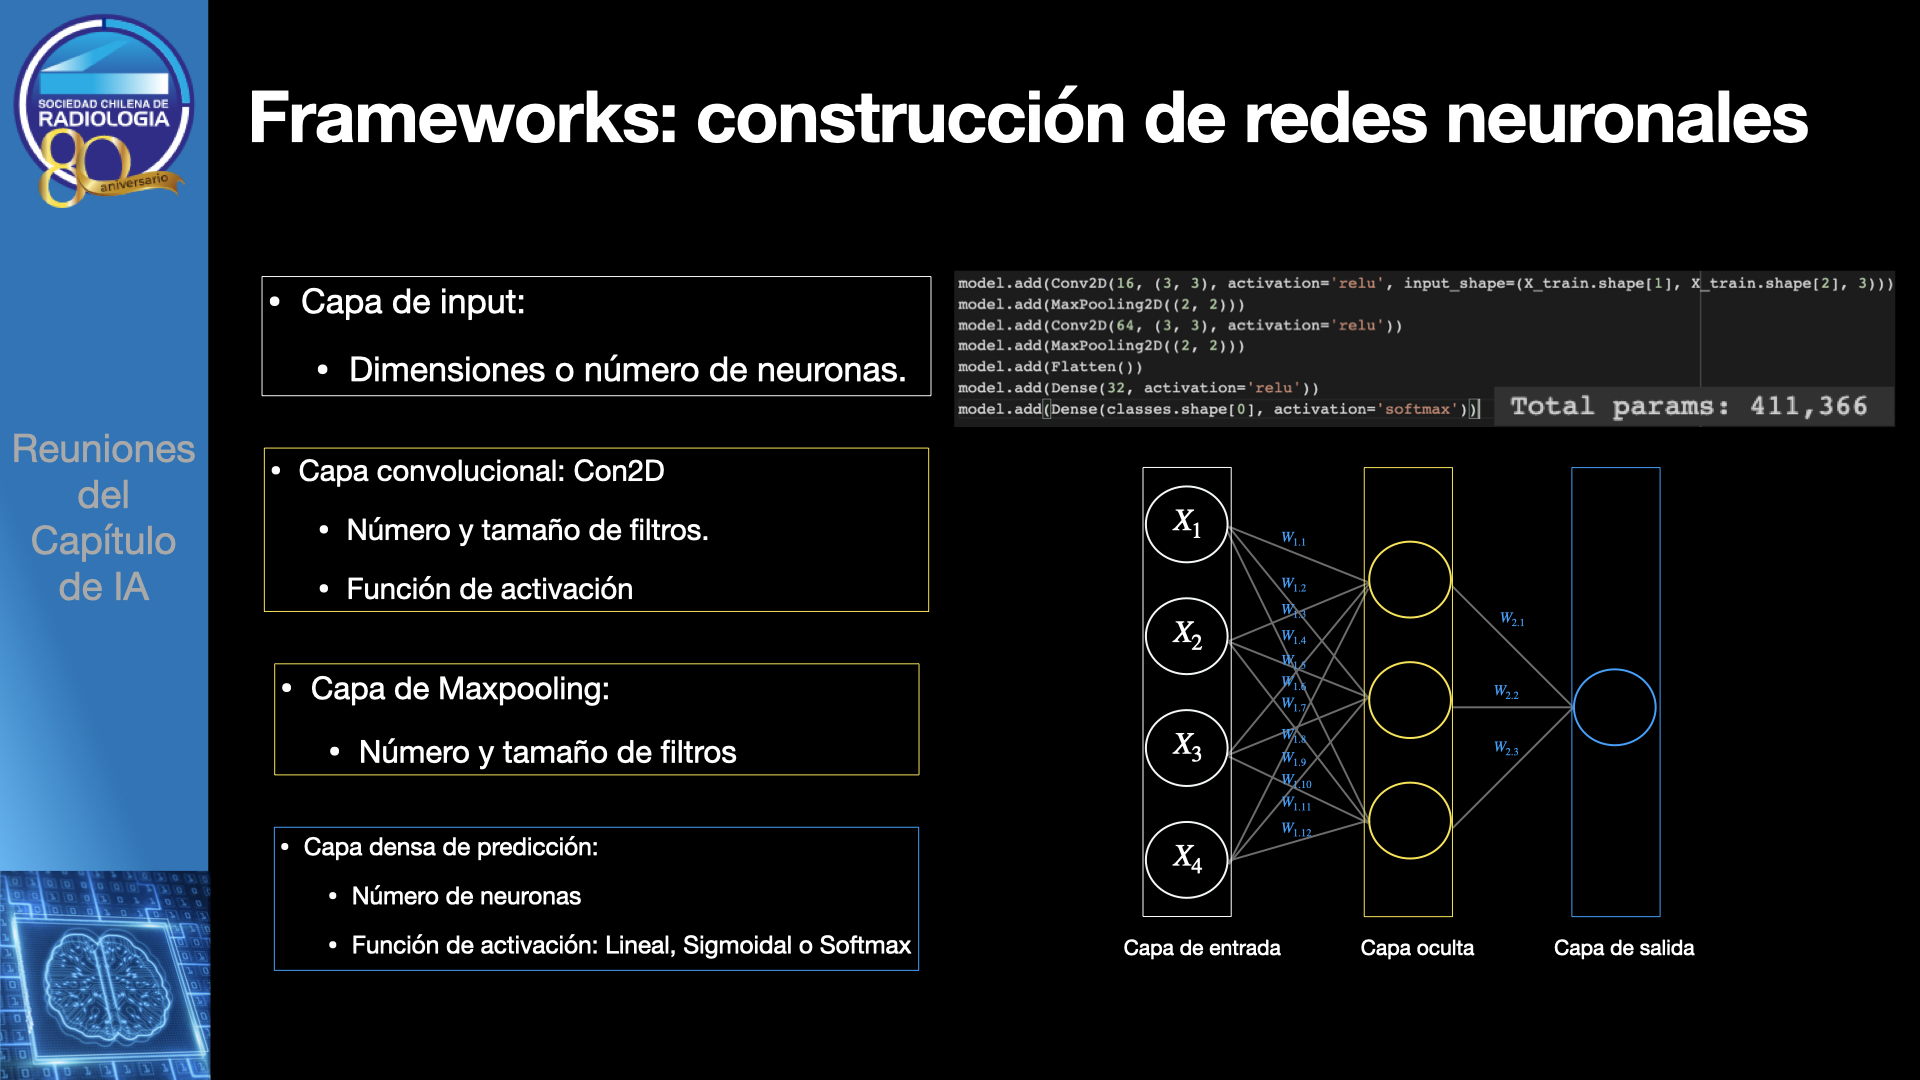

In [ ]:
tf.keras.backend.clear_session()

model = Sequential()

## Primera capa: Input y primera convolución:
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 3)))
model.add(MaxPooling2D((2, 2)))

## Segunda capa convolucional:
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

## Aplanado del vector y clasificación:
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(classes.shape[0], activation='softmax'))

## Muestra resumen del modelo:
model.summary()

In [ ]:
## Visualizando la red neuronal
visualizer(model, file_name='mi_primera_red_neuronal', file_format='png', view=False, settings=None)

In [ ]:
## Hiperparámetros:
EPOCHS = 2
BATCH_SIZE = 64
LR = 0.005

### Configuración de Callbacks:
def scheduler(epoch, learning_rate):
    if epoch < 3:
        return learning_rate
    else:
        return learning_rate * tf.math.exp(-0.05)
lr_scheduler = LearningRateScheduler(scheduler)

checkpoint_filepath = './checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

## Compilado y entrenamiento
model.compile(optimizer=Adam(learning_rate=LR), loss = 'binary_crossentropy', metrics='accuracy')
history = model.fit(X_train, train_labels, epochs= EPOCHS, verbose= 1, batch_size= BATCH_SIZE, 
                validation_data=(X_test, test_labels), shuffle= True,
                callbacks=[model_checkpoint_callback,lr_scheduler])


In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, accuracy, 'bo', label='Training accuracy', color='salmon')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy', color='dodgerblue')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss', color='salmon')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color='dodgerblue')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Probando el modelo

In [ ]:
pred_scores = model.predict(X_test)
y_pred = np.where(pred_scores > 0.5, 1, 0)
print(classification_report(test_labels, y_pred, target_names = classes))

In [ ]:
numero = np.random.randint(0, X_test.shape[0])
print('caso Test:', numero)

img = X_test[numero]
img_tensor = np.expand_dims(img, axis=0) 

prediccion = model.predict(img_tensor)
print("vector de predicción:", prediccion)
print(". " *3)
print("Respuesta correcta:",classes[np.argmax(test_labels[numero])] )
print("Predicción del modelo:", classes[np.argmax(prediccion)])
print(". " *3)

heatmap_array, heatmap_resized = MapaActivacion(img_tensor, model)

f = plt.figure(figsize=(10,10), frameon=False)

f.add_subplot(1, 3, 1)
plt.title("imagen original")
plt.imshow(img.reshape(img.shape[0],img.shape[1],3), cmap='gray')

f.add_subplot(1, 3, 2)
plt.title("Mapa de Activación")
plt.imshow(heatmap_array, cmap='gnuplot', interpolation='gaussian')

f.add_subplot(1, 3, 3)
plt.title("Fusión")
plt.imshow(img, cmap='gnuplot')
plt.imshow(heatmap_resized, cmap='gnuplot',alpha=0.8)

plt.show()